# Distribution of Federal Dollars by State

A question has arisen regarding the relationship between the state and local tax deduction and the distribution of federal expenditure by state.  This notebook seeks to probe this question a bit by way of the [Government Finance Statistics](http://www.census.gov/govs/local/) provided by the Census.

In [61]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sb

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data Input

The first thing we need to do is capture 1) the GFS data, 2) federal receipts by state, and 3)population data needed to generate a view of per capita dollars.  The GFS data is taken from a conveniently [aggregated state table](http://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?src=bkmk) housed on American FactFinder.  Federal receipts are from the [IRS](https://www.irs.gov/uac/SOI-Tax-Stats-Gross-Collections,-by-Type-of-Tax-and-State,-Fiscal-Year-IRS-Data-Book-Table-5).  Population counts by state are 3-year ACS estimates we have also grabbed from American FactFinder.  Both government revenue data sets come from fiscal year 2013.  The population data are three year averages centered on 2013...

In [62]:
#Establish working directory
workdir='O:/Analyst/Marvin/BudgetOptions/GFS2013/'

#Read in mapping of variable names for both sets
var_map_gfs_df=pd.read_csv(workdir+'SLF_2013_SLF003_metadata.csv',names=['var','desc'])
var_map_gfs=dict(zip(var_map_gfs_df['var'],var_map_gfs_df['desc']))
var_map_pop_df=pd.read_csv(workdir+'ACS_13_3YR_B01003_metadata.csv',names=['var','desc'])
var_map_pop=dict(zip(var_map_pop_df['var'],var_map_pop_df['desc']))

#Read in data
gfs=pd.read_csv(workdir+'SLF_2013_SLF003.csv')
pop=pd.read_csv(workdir+'ACS_13_3YR_B01003.csv')
irs=pd.read_csv(workdir+'federal_receipts_by_state_fy2013.csv')

#Capture GEO.id in dict
st_map=dict(zip(gfs['GEO.display-label'],gfs['GEO.id']))
st_map_rev={v:k for k,v in st_map.items()}

#Generate GEO.id var for irs data
irs['GEO.id']=irs['state'].map(st_map)

#Capute list of DFs
dfs=[pop,gfs,irs]

#Set indices
for df in dfs:
    df.set_index('GEO.id',inplace=True)

print pop.head(),'\n'
print irs.head(),'\n'
print gfs.head()

             GEO.id2 GEO.display-label  HD01_VD01  HD02_VD01
GEO.id                                                      
0400000US01        1           Alabama    4817624        NaN
0400000US02        2            Alaska     729603        NaN
0400000US04        4           Arizona    6548856        NaN
0400000US05        5          Arkansas    2949238        NaN
0400000US06        6        California   38000360        NaN 

                  state      receipts
GEO.id                               
0400000US01     Alabama  2.376576e+07
0400000US02      Alaska  5.292703e+06
0400000US04     Arizona  3.676905e+07
0400000US05    Arkansas  2.877227e+07
0400000US06  California  3.344247e+08 

             GEO.id2 GEO.display-label    Amt1_REV  CV1_REV      A2_REV  \
GEO.id                                                                    
0100000US        NaN     United States  3419868195     0.07  2193443291   
0400000US01        1           Alabama    44644352     0.53    29092950   
040

As we can see, the ID info matches well, so we have a good merge key.  We clearly do not need all of these variables, so let's cut down to a few key concepts:

+ State and Local Own Source Revenue (`Amt1_REV` in `gfs`)
+ Federal Transfers to the State (`Amt1_FROMFED` in `gfs`)
+ Federal Taxes Paid (`receipts` in `irs`)
+ Population (`HD01_VD01` in `pop`)
+ State (`GEO.display-label` in `gfs & pop`; `state` in `irs`)
+ GEOID (`GEO.id` in `gfs & pop`)

We can subset to these variables and create a consolidated set.  Let's first make sure we have common elements in the index.

In [63]:
#Capture common set of GEO.ids
geo_ids=list(set(pop.index) & set(gfs.index) & set(irs.index))

#For each geo id in our state mapping...
for idx in st_map.values():
    #...if we don't find it in the common set of geo ids...
    if idx not in geo_ids:
        #...tell me about it
        print idx,'|',st_map_rev[idx]

0100000US | United States


Now we can join these DataFrames together.

In [64]:
#Join Census sets together
data=DataFrame(pop['HD01_VD01']).join([gfs[['Amt1_REV','Amt1_FROMFED']],irs]).reset_index()

#Drop the GEO.id
data.pop('GEO.id')

#Set index
data.set_index('state',inplace=True)

#Change column names
data.columns=['pop','own_src_rev','fed_igr','fed_tax_pd']

data

,pop,own_src_rev,fed_igr,fed_tax_pd
state,,,,
Alabama,4817624,44644352,9186815,2.376576e+07
Alaska,729603,17371758,3004845,5.292703e+06
Arizona,6548856,57247325,11173613,3.676905e+07
Arkansas,2949238,26683523,6015670,2.877227e+07
California,38000360,503939325,66803001,3.344247e+08
Colorado,5192076,54853161,7795888,4.653887e+07
Connecticut,3592264,45506342,6584182,5.370334e+07
Delaware,916929,10912225,2004163,2.006183e+07
District of Columbia,633167,14093322,3982425,2.446435e+07


That last row actually holds the population of Puerto Rico, which we don't care about for the moment.

In [65]:
data=data.ix[:'Wyoming']

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51 entries, Alabama to Wyoming
Data columns (total 4 columns):
pop            51 non-null int64
own_src_rev    51 non-null float64
fed_igr        51 non-null float64
fed_tax_pd     51 non-null float64
dtypes: float64(3), int64(1)
memory usage: 2.0+ KB


## Establishing a Basis for Comparison

At the current time, we want to know the relationship between dollars received from the federal government (`fed_igr`) and dollars sent to the federal government (`fed_tax_pd`).  One measure of use would be the ratio of federal intergovernmental revenue received to taxes paid.

It would also be illuminating to understand tax effort across the states.  What is, for example, the own source tax cost per capita?

*Note that while the population figures are in absolute terms, the dollar figures are in \$000s.*

In [66]:
#Capture ratio of federal igr to taxes paid
data['fed_ratio']=data['fed_igr']/data['fed_tax_pd']

#Capture avg tax effort
data['effort']=(data['own_src_rev']/data['pop'])*1000.

data.head()

C:\Users\marvinw\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
C:\Users\marvinw\AppData\Local\Continuum\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,pop,own_src_rev,fed_igr,fed_tax_pd,fed_ratio,effort
state,,,,,,
Alabama,4817624,44644352,9186815,2.376576e+07,0.386557,9266.881766
Alaska,729603,17371758,3004845,5.292703e+06,0.567734,23809.877426
Arizona,6548856,57247325,11173613,3.676905e+07,0.303886,8741.576391
Arkansas,2949238,26683523,6015670,2.877227e+07,0.209079,9047.599075
California,38000360,503939325,66803001,3.344247e+08,0.199755,13261.435550


Is there a relationship between the federal ratio and tax effort?

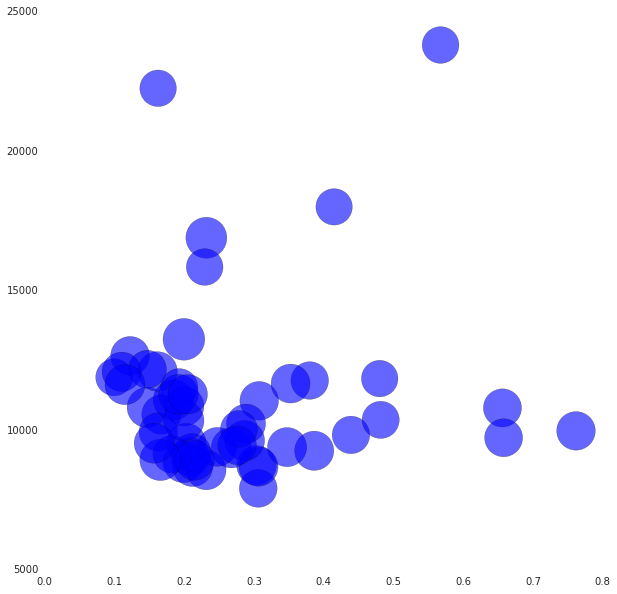

In [70]:
#Generate plot object
fig,ax=plt.subplots(figsize=(10,10))

#Plot ratio vs tax effort
ax.scatter(data['fed_ratio'],data['effort'],s=data['pop'].apply(lambda x: np.log(x)*100),alpha=.6)